# <b> <center> <font color='blue'> SALARY PREDICTION </font> </color> </b>

## Table of Contents

1. [Problem Statement](#1)
2. [Modules](#2)
3. [Helper Functions](#3)
4. [Data Loading, Exploration and Pre-processing](#4)
5. [Baseline model](#5)
6. [Build, compile and train the model](#5)
7. [Making predictions](#7)


<a name="1"></a>
## <b> <font color='#21618C'> 1. Problem Statement </font> </color>

We are going to predict the salary using only the feature "years of experience"

<a name="2"></a>
## <b> <font color='#21618C'> 2. Modules </font> </color>

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import warnings
warnings.filterwarnings('ignore')

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

<a name="3"></a>
## <b> <font color='#21618C'> 3. Helper Functions </font> </color>

In [45]:
# plotting utilities

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    axs[0].set_title('MAE',fontsize=14, fontweight='bold',color='red')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Mean Abs Error [MPG]')
    axs[0].plot(hist['epoch'], hist['mae'],
           label='Train Error')
    axs[0].plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    axs[0].legend()


    axs[1].set_title('MSE',fontsize=14, fontweight='bold',color='orange')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Mean Square Error [$MPG^2$]')
    axs[1].plot(hist['epoch'], hist['mse'],
           label='Train Error')
    axs[1].plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    axs[1].legend()


<a name="4"></a>
## <b> <font color='#21618C'> 4. Data Loading, Exploration and Pre-processing </font> </color>

### Loading data

In [9]:
!ls data

'Salary Data.csv'


In [10]:
df = pd.read_csv('data/Salary Data.csv')

df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


### Exploring and pre-processing

In [15]:
df.shape

(375, 6)

In [16]:
df.columns

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')

Eliminte Nan Values

In [18]:
total_nan_values = df.isnull().sum().sum()
print(total_nan_values)

total_nan_values = df.isna().sum().sum()
print(total_nan_values)

12
12


In [19]:
df.dropna(inplace=True)

ckeck

In [23]:
total_nan_values = df.isnull().sum().sum()
print(total_nan_values)

total_nan_values = df.isna().sum().sum()
print(total_nan_values)

0
0


The feature will be "Years of Experience", and label "Salary".

In [24]:
X = df[['Years of Experience']].copy()
y = df['Salary']

type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

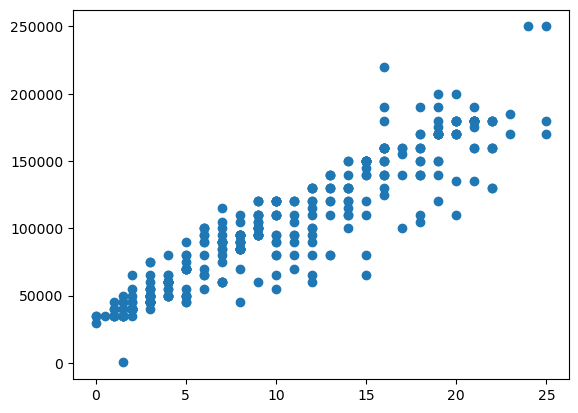

In [25]:
plt.scatter(X,y)

We can see a linear relation.

<b> Train/test split </b>

In [27]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's do some more pre-processing:

We're gonna normalize our input data X.

We're going to use ScikitLearn's MinMaxScaler(), which normalizes the data by scaling the features to a specified range, typically between 0 and 1, based on the minimum and maximum values present in the data.

In [30]:
# Create column transformer to apply transformations to specific columns
ct = make_column_transformer(
    (MinMaxScaler(), ["Years of Experience"]),  # Normalize "Years of Experience" column
    remainder='passthrough'  # Pass through columns not specified for transformation
)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScaler) and pass through the rest
X_train_transformed = ct.transform(X_train)
X_test_transformed = ct.transform(X_test)

<b>Note.</b> When you fit the transformer using X_train, you are essentially learning the parameters of the transformation based on the training data. This ensures that the transformation is applied consistently to both the training and testing data.

Fitting the transformer on the training data helps prevent data leakage, which can occur when information from the testing set inadvertently influences the model training process. It ensures that the preprocessing steps are learned solely from the training data, which reflects the real-world scenario where the model will be deployed on unseen data.

In [32]:
X_train_transformed.shape, y_train.shape

((298, 1), (298,))

<a name="5"></a>
## <b> <font color='#21618C'> 5. Baseline Model </font> </color>


We are going to use the linear regression estimator of Scikit Learn.

In [37]:
# Create a linear regression model
baseline_model = LinearRegression()

# Fit the model on the training data
baseline_model.fit(X_train_transformed, y_train)

# Make predictions on the testing data
y_pred = baseline_model.predict(X_test_transformed)

# Calculate Mean Absolute Error (MAE)
baseline_mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
baseline_mse = mean_squared_error(y_test, y_pred)

In [38]:
baseline_mae, baseline_mse

(12094.170341194764, 241834883.8999349)

<a name="6"></a>
## <b> <font color='#21618C'> 6. Build, compile and train model </font> </color>

In [52]:
def build_model(input_shape):
    model = tf.keras.Sequential([
        layers.Dense(128,input_shape=[input_shape]),
        layers.Dense(128),
        layers.Dense(128),
        tf.keras.layers.Dense(64),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [53]:
model = build_model(X_train_transformed.shape[1])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               256       
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 41601 (162.50 KB)
Trainable params: 41601 (162.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We are going to configure validation_split, which indicates the fraction of data to be used as the validation set. In this case, 20% of the data will be used as the validation set, and the remaining 80% will be used as the training set.

In [54]:
history = model.fit(
        X_train_transformed,y_train,
        validation_split=0.2,
        epochs=100,
        verbose=0
)

In [55]:
scores = model.evaluate(X_test_transformed, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 234944928.0000 - mae: 11620.0791 - mse: 234944928.0000


We have already surpassed the logistic regression estimator from scikit-learn!

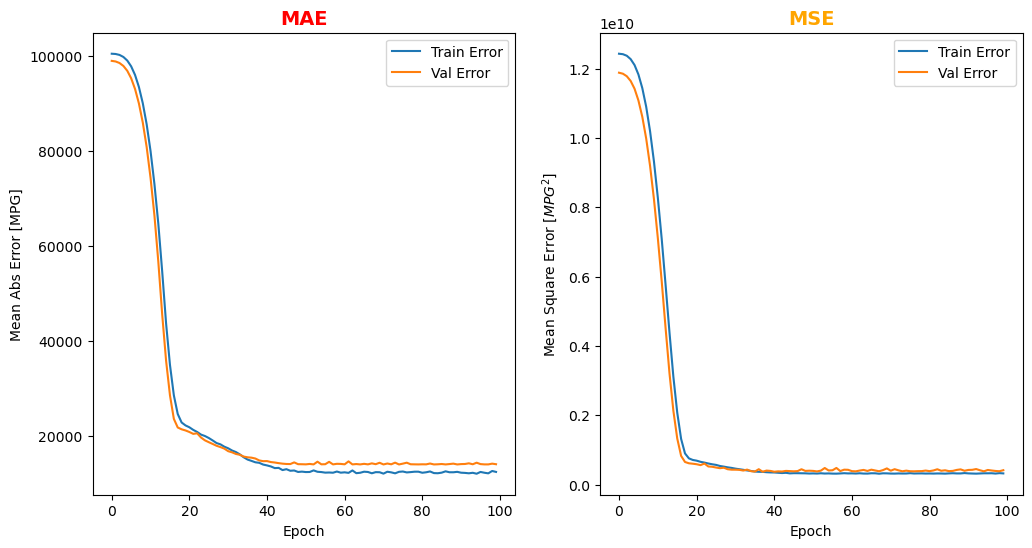

In [58]:
plot_history(history)

<a name="7"></a>
## <b> <font color='#21618C'> 7. Making predictions </font> </color>

In [63]:
# example of data
data = {
    "Years of Experience": [5.0, 3.0, 15.0]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# we applied the same preprocessing as the data used to train the model.
input_transformed = ct.transform(df)


# Make predictions using the normalized input
predictions = model.predict(input_transformed)

1/1 [==============================] - 0s 14ms/step


In [64]:
predictions

array([[ 66006.96 ],
       [ 51913.477],
       [136474.38 ]], dtype=float32)